In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install imageio>=2.31.6


In [4]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 16249, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 16249 (delta 53), reused 93 (delta 39), pack-reused 16103
Receiving objects: 100% (16249/16249), 15.09 MiB | 25.92 MiB/s, done.
Resolving deltas: 100% (11084/11084), done.
/content/yolov5/yolov5


# **加载模型**

In [5]:
from pickle import FALSE
import cv2
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet50
import os

classes = {0: 'pothole'}
colors = {'pothole': (0,50,255)}

# 定义相机参数
fov = 60.0  # 视角
camera_height = 1.2  # 相机高度

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
path = '/kaggle/input/model-weights'
pathlist = [path + '/' + fil for fil in os.listdir(path)]
print(pathlist)
'''

# 定义ResNet50模型
class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.resnet50 = resnet50(pretrained=True)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet50(x)



# 加载ResNet50模型
resnet_model = ResNet50()
resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/model-weights/ResNet50_model/resnet50_model.pth',map_location=device), strict=False)
resnet_model = resnet_model.to(device)
resnet_model.eval()


# 加载Yolov5模型
yolov5_model = torch.hub.load('ultralytics/yolov5', 'custom',
                       path='/content/drive/MyDrive/model-weights/YOLOv5_model/YOLOv5_model/best.pt', force_reload=True)
yolov5_model = yolov5_model.to(device)
yolov5_model.eval()





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.4MB/s]
/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add 

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 80, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1

# **数据处理**

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image):
    # Convert OpenCV BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert NumPy array to PIL
    image_pil = Image.fromarray(image)

    # Apply the transformation
    input_tensor = transform(image_pil).unsqueeze(0).to(device)

    return input_tensor




# **判断坑洼位置**

In [7]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def calculate_distance_to_camera(image_point, image_size, fov, camera_height):
    # 计算相机到图像中心的距离
    camera_distance = (image_size[0] / 2) / np.tan(np.radians(fov / 2))

    camera_distance = camera_distance/360

    # 计算在相机坐标系下的坐标
    camera_x = image_point[0] - image_size[0] / 2
    camera_y = image_size[1] / 2 - image_point[1]


    camera_x = camera_x/240
    camera_y = camera_y/240


    # 计算点到相机的距离
    distance = np.sqrt(camera_x**2 + camera_y**2 + camera_distance**2)

    # 计算点到人的距离
    distance = np.sqrt(distance**2 - camera_height**2)

    return distance



# **加边框和提示语**

In [8]:
def draw_focused_rectangle(image, bbox, color, corner_length = 30, corner_thickness = 4, edge_thickness = 1):
    img = image.copy()

    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if (x1+corner_length > x2) or (y1+corner_length > y2):
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
        # top left corner
        cv2.line(img, (x1, y1), (x1+corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y1), (x1, y1+corner_length), color = color, thickness = corner_thickness)
        # top right corner
        cv2.line(img, (x2, y1), (x2-corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y1), (x2, y1+corner_length), color = color, thickness = corner_thickness)
        # bottom left corner
        cv2.line(img, (x1, y2), (x1+corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y2), (x1, y2-corner_length), color = color, thickness = corner_thickness)
        # bottom right corner
        cv2.line(img, (x2, y2), (x2-corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y2), (x2, y2-corner_length), color = color, thickness = corner_thickness)

    image = img.copy()

    return image

def draw_label(image, label, x, y, box_color, font_color, font_face = cv2.FONT_HERSHEY_SIMPLEX, font_scale = 0.5):
    img = image.copy()

    text_size = cv2.getTextSize(label, fontFace=font_face, fontScale=font_scale, thickness=1)
    dim, baseline = text_size[0], text_size[1]

    # cv2.rectangle(img, (x,y), (x + dim[0], y + dim[1] + baseline), box_color, cv2.FILLED);
    # cv2.putText(img, label, (x, y + dim[1] + 2), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=1)

    cv2.rectangle(img, (x, y - dim[1] - baseline), (x + dim[0], y), box_color, cv2.FILLED);
    cv2.putText(img, label, (x, y - dim[1] + 7), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=1)

    image = img.copy()



    return image

In [9]:
from PIL import Image, ImageDraw, ImageFont

def add_text_to_image_center(image, text):
    #image 元组

    image = np.array(image, dtype=np.uint8)  #数组

    image_width, image_height,_ = np.array(image).shape

    image = Image.fromarray(image) #PIL.Image对象

    draw = ImageDraw.Draw(image)

    #font = ImageFont.load_default()
    font_size = 50
    new_font = ImageFont.truetype("/content/drive/MyDrive/font/xuandongkaishu.ttf", font_size)


    text_color = (255, 255, 255)

    text_bbox = draw.textbbox((0, 0), text, font=new_font)

    text_x, text_y, text_width, text_height = text_bbox

    text_position = ((image_width - text_width) // 2, (image_height - text_height) // 2)


    draw.text(text_position, text, font=new_font, fill=text_color)

    img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    return img





In [10]:
def draw_label_bottom(img, x, y,  text_color, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.3, fov = 60, camera_height = 1.2):
    image_point = (x, y)

    distance = calculate_distance_to_camera(image_point, img.shape, fov, camera_height )
    distance_text = f"{distance:.2f} m"


    (text_width, text_height), baseline = cv2.getTextSize(distance_text, font, font_scale, 1)


    cv2.rectangle(img, (x, y + baseline), (x + text_width, y - text_height), (0,0,0), cv2.FILLED)


    cv2.putText(img, distance_text, (x, y), font, font_scale, text_color, 1, cv2.LINE_AA)

    image = img.copy()


    return image


# ***坑洼识别***

In [11]:
def detect_image(image_bgr, yolov5_model, classes, colors):
    img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    results = yolov5_model(img)
    detections = results.crop(save = False)
    detection_threshold = 0.4
    plant = 1 #图片中的不是坑

    for i in range(len(detections)):
        if detections[i]['conf'].cpu().numpy() >= detection_threshold:
          plant = 0
          break

    if len(detections) == 0 or plant == 1:
        #if len(detections) == 0 :
        #  print("没有坑")
        #print("道路正常，可通行！")
        image = Image.fromarray(img)
        text = "道路正常，可通行！"
        #text = "The road is normal and passable！"
        img = add_text_to_image_center(image, text)
        return img

    #print("道路存在威胁，请留意脚下！")
    for i in range(len(detections)):
        if detections[i]['conf'].cpu().numpy() >= detection_threshold:
            xmin = int(detections[i]['box'][0].cpu().numpy())
            ymin = int(detections[i]['box'][1].cpu().numpy())
            xmax = int(detections[i]['box'][2].cpu().numpy())
            ymax = int(detections[i]['box'][3].cpu().numpy())
            cls_id = int(detections[i]['cls'].cpu().numpy())
            conf = int(detections[i]['conf'].cpu().numpy()*100)
            cls = classes[cls_id]
            color = colors[cls][::-1]
            label = f'{cls}: {conf}%'

            #cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color = color, thickness = 2)
            img = draw_focused_rectangle(img, (xmin, ymin, xmax, ymax), color)
            img = draw_label(img, label, xmin, ymin, color, (255,255,255), cv2.FONT_HERSHEY_SIMPLEX, 0.5)


            image_point = (xmin, ymax + 20)
            draw_label_bottom(img, xmin, ymax + 20, (255,255,255), cv2.FONT_HERSHEY_SIMPLEX, 0.3, fov, camera_height,)

    text = "道路存在威胁，请留意脚下！"
    #text = "There is a threat on the road， please watch your step！"
    img = add_text_to_image_center(img, text)


    return img

# **道路预测**

In [12]:
def predict(frame):
    # 使用ResNet50模型判断道路平坦与否
    input_tensor = preprocess_image(frame)
    predictions = 0
    with torch.no_grad():
        resnet_output = resnet_model(input_tensor)
        predictions = torch.argmax(resnet_output, dim=1)

    if predictions == 0:
        #print("道路正常，可通行！")
        text = "道路正常，可通行！"
        #text = "The road is normal and passable！"
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = add_text_to_image_center(img, text)
        return img

    #####

    img = detect_image(frame, yolov5_model, classes, colors)




    return img


# **图片预测**

<ipython-input-36-3ffe0ea2b39b>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  sample_image = sample_image.resize((720,720), Image.ANTIALIAS)


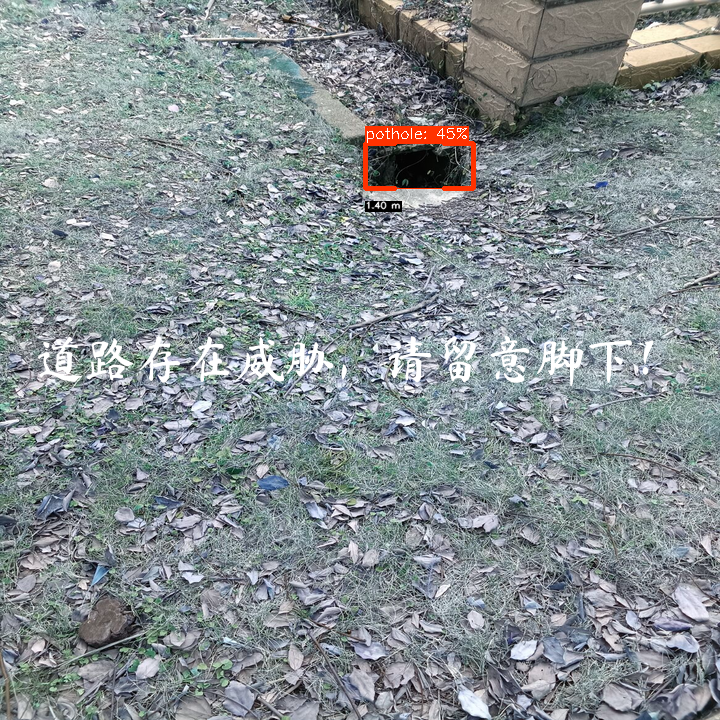

In [36]:
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

images_paths = ['/content/drive/MyDrive/pothole-detection-testdata/images_data/' + fil for fil in os.listdir('/content/drive/MyDrive/pothole-detection-testdata/images_data')]
sample_image_path = random.sample(images_paths, 1)[0]
sample_image = cv2.imread(sample_image_path)



if sample_image is not None:
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = Image.fromarray(sample_image)
    sample_image = sample_image.resize((720,720), Image.ANTIALIAS)
    sample_image = np.array(sample_image)
    predict_img = predict(sample_image)
    cv2_imshow(predict_img)
    '''
    # 显示图像
    plt.imshow(sample_image_rgb)
    plt.axis('off')
    plt.show()
    '''
else:
    print(f"Error: Unable to read the image from {sample_image_path}")

# **实时预测**

In [38]:
# 读取视频
video_path = '/content/drive/MyDrive/pothole-detection-testdata/video.mp4'
cap = cv2.VideoCapture(video_path)

# 获取视频信息
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 创建输出视频
output_path = '/content/drive/MyDrive/result/result_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
i = 0

result_img = '/content/drive/MyDrive/result/result_img'
os.makedirs(result_img, exist_ok=True)

#处理视频帧
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frame = frame.resize((720,720), Image.ANTIALIAS)
    frame = np.array(frame)
    annotated_frame = predict(frame)
    annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)

    image = Image.fromarray(annotated_frame)
    image = np.array(image)

    out.write(image)
    #cv2_imshow( annotated_frame)
    #img = Image.fromarray(annotated_frame)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    i = i + 1
    output_path = os.path.join(result_img, 'img{}.jpg'.format(i))
    cv2.imwrite(output_path, img)
    #img.save('/content/drive/MyDrive/result/result_img/img{}.jpg'.format(i))

    '''
    plt.imshow('Video',annotated_frame)
    plt.axis('off')
    plt.show()
    '''

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
print("处理完成！")

# 释放资源
cap.release()
out.release()
cv2.destroyAllWindows()

<ipython-input-38-94a3cd540f69>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  frame = frame.resize((720,720), Image.ANTIALIAS)
<ipython-input-38-94a3cd540f69>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  frame = frame.resize((720,720), Image.ANTIALIAS)
<ipython-input-38-94a3cd540f69>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  frame = frame.resize((720,720), Image.ANTIALIAS)
<ipython-input-38-94a3cd540f69>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  frame = frame.resize((720,720), Image.ANTIALIAS)
<ipython-input-38-94a3cd540f69>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (20

处理完成！


# **播放视频**

In [15]:
#cloab上视频处理有误
'''
from IPython.display import display, HTML
from base64 import b64encode

# Convert the video to base64 encoding
video_path = "/content/drive/MyDrive/result/result_video.mp4"
video_file = open(video_path, "rb").read()
video_encoded = b64encode(video_file).decode("utf-8")

# Display the video using HTML5 video tag
display(HTML(f'<video alt="test" controls><source src="data:video/mp4;base64,{video_encoded}" type="video/mp4" /></video>'))
'''
